In [34]:
# Imports
import numpy as np
import pandas as pd
import os
from utils.utilities import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline    

#加载原始数据
raw_data = pd.read_csv(r"D:\py_projects\ML\ML_Demo\financial\creditGrade_train_datas.csv", encoding='gbk')
#缺失值处理
data = raw_data.fillna(0)

In [2]:
#2700*106
features_data = (data.drop(['id','label1','label2'],axis=1))
#5-class
target = data.label2
X = features_data.values.astype(np.float32) # 转换数据类型

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, target, test_size=0.3, random_state=123) # 参数test_size设置训练集占比

In [4]:
#Normalization
from sklearn import preprocessing
X_train = preprocessing.normalize(X_train, norm='l2')
X_test = preprocessing.normalize(X_test, norm='l2')


In [5]:
#对分类进行one-hot编码
y_tr = one_hot(y_train.astype(np.int64),5)
y_vld = one_hot(y_test.astype(np.int64),5)

In [23]:
import tensorflow as tf

#设置相关参数
batch_size = 200    # Batch size
features_num = 106        # Number of steps
learning_rate = 0.0005
epochs = 1000

n_classes = 5
#一维数据，通道数设置为
n_channels = 1

log_dir = r'D:\py_projects\ML\ML_Demo\financial\logs'    # 输出日志保存的路径

In [24]:
graph = tf.Graph()
# Construct placeholders
with graph.as_default():
    inputs_ = tf.placeholder(tf.float32, [None, features_num,n_channels], name = 'inputs')
    labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels')
    #keep_prob目的是为了减少过拟合情况，动态调整让部分神经元参与训练过程
    keep_prob_ = tf.placeholder(tf.float32, name = 'keep')
    learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate')

In [25]:
with graph.as_default():
    # (batch, 106, 1) --> (batch, 53, 18)
    conv1 = tf.layers.conv1d(inputs=inputs_, filters=10, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu) 
    #conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob_)
    #max_pool_1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2, padding='same')
    #print(max_pool_1)
    # (batch, 53, 18) --> (batch, 27, 36)
    conv2 = tf.layers.conv1d(inputs=conv1, filters=20, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    #max_pool_2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2, padding='same')
    #print(max_pool_2)
    # (batch, 27, 36) --> (batch, 14, 72)
    #conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob_)
    conv3 = tf.layers.conv1d(inputs=conv2, filters=40, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    #max_pool_3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2, padding='same')
    conv3 = tf.nn.dropout(conv3, keep_prob=keep_prob_)
    # (batch, 14, 72) --> (batch, 7, 144)
    conv4 = tf.layers.conv1d(inputs=conv3, filters=80, kernel_size=2, strides=1, 
                             padding='same', activation = tf.nn.relu)
    #max_pool_4 = tf.layers.max_pooling1d(inputs=conv4, pool_size=2, strides=2, padding='same')
    print(conv4)

Tensor("conv1d_4/Relu:0", shape=(?, 106, 80), dtype=float32)


In [26]:
with graph.as_default():
    # Flatten and add dropout,一个神经元的输出在dropout时不被丢弃的概率
    flat = tf.reshape(conv4, (-1,106*80))  
    flat = tf.nn.dropout(flat, keep_prob=keep_prob_)
    
    # Predictions
    #经网络的最后一层是逻辑层，这层会返回我们的预测原始结果值
    #代价函数参数[batch_size,n_class]
    logits = tf.layers.dense(flat, n_classes)
    # Cost function and optimizer
        #二次代价函数，计算预测值与真实值之间的误差代价值-loss，其中第一个参数logits为最后一层输出，第二个为训练目标值即分类值
        #先通过Softmax函数，输出X对应输出每一类的概率大小，其次和真实值进行“交叉熵”，最终，对向量求均值，得到代价loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_))
    
    #梯度下降法，数据量选择AdamOptimizer
    optimizer = tf.train.AdamOptimizer(learning_rate_).minimize(cost)
    
    # Accuracy
        #correct_pred 返回一个布尔型数组，通过转化为0-1值后来计算准确率
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')
    #预测值
    pred = tf.argmax(logits, 1)
    #正确值
    label = tf.argmax(labels_, 1)

tf.summary.scalar("accuracy", accuracy)
tf.summary.scalar('loss_function', cost)

<tf.Tensor 'loss_function:0' shape=() dtype=string>

In [27]:
if (os.path.exists(r'D:\py_projects\ML\ML_Demo\financial\checkpoints') == False):
    !mkdir checkpoints

In [28]:
validation_acc = []
validation_loss = []

train_acc = []
train_loss = []

with graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 1
    # summaries合并
    merged = tf.summary.merge_all()    
    # 写到指定的磁盘路径中
    train_writer = tf.summary.FileWriter(log_dir + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(log_dir + '/test')
    # Loop over epochs
    for e in range(epochs):
        
        # Loop over batches
        for x,y in get_batches(X_train, y_tr, batch_size):
            x = x.reshape((batch_size, features_num, n_channels))
            # Feed dictionary
            #keep_prob：0.5表示只有一半神经元运行在网络
            feed = {inputs_ : x, labels_ : y,keep_prob_ : 0.4, learning_rate_ : learning_rate}
             # Loss
            summary_str, loss, _ , acc = sess.run([merged, cost, optimizer, accuracy], feed_dict = feed)
         
            train_acc.append(acc)
            train_loss.append(loss)
            # Print at each 5 iters
            if (iteration % 5 == 0):
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Train loss: {:6f}".format(loss),
                      "Train acc: {:.6f}".format(acc))
                train_writer.add_summary(summary_str, e);
            # Compute validation loss at every 10 iterations
            if (iteration % 10 == 0):                
                val_acc_ = []
                val_loss_ = []
                
                for x_v, y_v in get_batches(X_test, y_vld, batch_size):
                    x_v = x_v.reshape(batch_size,features_num,n_channels)
                    # Feed
                    feed = {inputs_ : x_v, labels_ : y_v, keep_prob_ : 1.0}  
                    
                    # Loss
                    summary, loss_v, acc_v, pred_labels = sess.run([merged, cost, accuracy, pred], feed_dict = feed)                    
                    val_acc_.append(acc_v)
                    val_loss_.append(loss_v)
                    
                # Print info
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {:d}".format(iteration),
                      "Validation loss: {:6f}".format(np.mean(val_loss_)),
                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))
                test_writer.add_summary(summary, e);
                # Store
                validation_acc.append(np.mean(val_acc_))
                validation_loss.append(np.mean(val_loss_))
            # Iterate 
            iteration += 1    
            
        
#     # 保存二进制模型
#     output_graph_def = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, output_node_names=['labels'])
#     with tf.gfile.FastGFile(r'D:\py_projects\ML\ML_Demo\financial\creditGrade.pb', mode='wb') as f:
#         f.write(output_graph_def.SerializeToString())

    saver.save(sess,"checkpoints-cnn/creditGrade.ckpt")

Epoch: 0/1000 Iteration: 5 Train loss: 1.601681 Train acc: 0.200000
Epoch: 0/1000 Iteration: 10 Train loss: 1.585520 Train acc: 0.250000
Epoch: 0/1000 Iteration: 10 Validation loss: 1.590498 Validation acc: 0.214444
Epoch: 0/1000 Iteration: 15 Train loss: 1.577511 Train acc: 0.215000
Epoch: 0/1000 Iteration: 20 Train loss: 1.553717 Train acc: 0.310000
Epoch: 0/1000 Iteration: 20 Validation loss: 1.559328 Validation acc: 0.385000
Epoch: 1/1000 Iteration: 25 Train loss: 1.528540 Train acc: 0.380000
Epoch: 1/1000 Iteration: 30 Train loss: 1.504777 Train acc: 0.460000
Epoch: 1/1000 Iteration: 30 Validation loss: 1.497952 Validation acc: 0.533889
Epoch: 1/1000 Iteration: 35 Train loss: 1.437680 Train acc: 0.555000
Epoch: 1/1000 Iteration: 40 Train loss: 1.385223 Train acc: 0.470000
Epoch: 1/1000 Iteration: 40 Validation loss: 1.382182 Validation acc: 0.548889
Epoch: 2/1000 Iteration: 45 Train loss: 1.322312 Train acc: 0.495000
Epoch: 2/1000 Iteration: 50 Train loss: 1.201405 Train acc: 0.56

Epoch: 18/1000 Iteration: 380 Train loss: 0.733118 Train acc: 0.685000
Epoch: 18/1000 Iteration: 380 Validation loss: 0.715136 Validation acc: 0.685000
Epoch: 18/1000 Iteration: 385 Train loss: 0.774536 Train acc: 0.625000
Epoch: 18/1000 Iteration: 390 Train loss: 0.829700 Train acc: 0.570000
Epoch: 18/1000 Iteration: 390 Validation loss: 0.714295 Validation acc: 0.682222
Epoch: 18/1000 Iteration: 395 Train loss: 0.734198 Train acc: 0.665000
Epoch: 19/1000 Iteration: 400 Train loss: 0.718492 Train acc: 0.685000
Epoch: 19/1000 Iteration: 400 Validation loss: 0.710522 Validation acc: 0.688333
Epoch: 19/1000 Iteration: 405 Train loss: 0.752650 Train acc: 0.685000
Epoch: 19/1000 Iteration: 410 Train loss: 0.803410 Train acc: 0.650000
Epoch: 19/1000 Iteration: 410 Validation loss: 0.708349 Validation acc: 0.691667
Epoch: 19/1000 Iteration: 415 Train loss: 0.902432 Train acc: 0.670000
Epoch: 19/1000 Iteration: 420 Train loss: 0.754111 Train acc: 0.675000
Epoch: 19/1000 Iteration: 420 Validat

Epoch: 35/1000 Iteration: 750 Train loss: 0.551894 Train acc: 0.780000
Epoch: 35/1000 Iteration: 750 Validation loss: 0.635851 Validation acc: 0.733333
Epoch: 35/1000 Iteration: 755 Train loss: 0.565936 Train acc: 0.770000
Epoch: 36/1000 Iteration: 760 Train loss: 0.676539 Train acc: 0.705000
Epoch: 36/1000 Iteration: 760 Validation loss: 0.626811 Validation acc: 0.736667
Epoch: 36/1000 Iteration: 765 Train loss: 0.562606 Train acc: 0.765000
Epoch: 36/1000 Iteration: 770 Train loss: 0.590308 Train acc: 0.710000
Epoch: 36/1000 Iteration: 770 Validation loss: 0.633395 Validation acc: 0.736667
Epoch: 36/1000 Iteration: 775 Train loss: 0.629361 Train acc: 0.720000
Epoch: 37/1000 Iteration: 780 Train loss: 0.670329 Train acc: 0.720000
Epoch: 37/1000 Iteration: 780 Validation loss: 0.620837 Validation acc: 0.733889
Epoch: 37/1000 Iteration: 785 Train loss: 0.566920 Train acc: 0.765000
Epoch: 37/1000 Iteration: 790 Train loss: 0.514427 Train acc: 0.790000
Epoch: 37/1000 Iteration: 790 Validat

Epoch: 53/1000 Iteration: 1115 Train loss: 0.595286 Train acc: 0.705000
Epoch: 53/1000 Iteration: 1120 Train loss: 0.603905 Train acc: 0.720000
Epoch: 53/1000 Iteration: 1120 Validation loss: 0.581038 Validation acc: 0.754444
Epoch: 53/1000 Iteration: 1125 Train loss: 0.704730 Train acc: 0.645000
Epoch: 53/1000 Iteration: 1130 Train loss: 0.656480 Train acc: 0.740000
Epoch: 53/1000 Iteration: 1130 Validation loss: 0.596276 Validation acc: 0.738889
Epoch: 54/1000 Iteration: 1135 Train loss: 0.592634 Train acc: 0.745000
Epoch: 54/1000 Iteration: 1140 Train loss: 0.603457 Train acc: 0.755000
Epoch: 54/1000 Iteration: 1140 Validation loss: 0.577795 Validation acc: 0.760000
Epoch: 54/1000 Iteration: 1145 Train loss: 0.622825 Train acc: 0.720000
Epoch: 54/1000 Iteration: 1150 Train loss: 0.719099 Train acc: 0.700000
Epoch: 54/1000 Iteration: 1150 Validation loss: 0.590381 Validation acc: 0.747778
Epoch: 54/1000 Iteration: 1155 Train loss: 0.575422 Train acc: 0.755000
Epoch: 55/1000 Iteration

Epoch: 70/1000 Iteration: 1480 Train loss: 0.593268 Train acc: 0.730000
Epoch: 70/1000 Iteration: 1480 Validation loss: 0.549846 Validation acc: 0.771667
Epoch: 70/1000 Iteration: 1485 Train loss: 0.454249 Train acc: 0.775000
Epoch: 70/1000 Iteration: 1490 Train loss: 0.512570 Train acc: 0.770000
Epoch: 70/1000 Iteration: 1490 Validation loss: 0.557450 Validation acc: 0.752222
Epoch: 71/1000 Iteration: 1495 Train loss: 0.566093 Train acc: 0.765000
Epoch: 71/1000 Iteration: 1500 Train loss: 0.500981 Train acc: 0.810000
Epoch: 71/1000 Iteration: 1500 Validation loss: 0.549145 Validation acc: 0.769444
Epoch: 71/1000 Iteration: 1505 Train loss: 0.512610 Train acc: 0.765000
Epoch: 71/1000 Iteration: 1510 Train loss: 0.600798 Train acc: 0.720000
Epoch: 71/1000 Iteration: 1510 Validation loss: 0.558167 Validation acc: 0.750556
Epoch: 72/1000 Iteration: 1515 Train loss: 0.533267 Train acc: 0.755000
Epoch: 72/1000 Iteration: 1520 Train loss: 0.503136 Train acc: 0.795000
Epoch: 72/1000 Iteration

Epoch: 87/1000 Iteration: 1840 Validation loss: 0.530599 Validation acc: 0.772222
Epoch: 87/1000 Iteration: 1845 Train loss: 0.517703 Train acc: 0.795000
Epoch: 88/1000 Iteration: 1850 Train loss: 0.605392 Train acc: 0.750000
Epoch: 88/1000 Iteration: 1850 Validation loss: 0.536531 Validation acc: 0.762778
Epoch: 88/1000 Iteration: 1855 Train loss: 0.532780 Train acc: 0.805000
Epoch: 88/1000 Iteration: 1860 Train loss: 0.600437 Train acc: 0.725000
Epoch: 88/1000 Iteration: 1860 Validation loss: 0.526193 Validation acc: 0.775555
Epoch: 88/1000 Iteration: 1865 Train loss: 0.540096 Train acc: 0.745000
Epoch: 89/1000 Iteration: 1870 Train loss: 0.525494 Train acc: 0.815000
Epoch: 89/1000 Iteration: 1870 Validation loss: 0.535200 Validation acc: 0.759444
Epoch: 89/1000 Iteration: 1875 Train loss: 0.495303 Train acc: 0.785000
Epoch: 89/1000 Iteration: 1880 Train loss: 0.558337 Train acc: 0.750000
Epoch: 89/1000 Iteration: 1880 Validation loss: 0.524727 Validation acc: 0.772222
Epoch: 89/1000

Epoch: 104/1000 Iteration: 2205 Train loss: 0.491448 Train acc: 0.780000
Epoch: 105/1000 Iteration: 2210 Train loss: 0.573862 Train acc: 0.765000
Epoch: 105/1000 Iteration: 2210 Validation loss: 0.507933 Validation acc: 0.778333
Epoch: 105/1000 Iteration: 2215 Train loss: 0.540422 Train acc: 0.745000
Epoch: 105/1000 Iteration: 2220 Train loss: 0.411561 Train acc: 0.815000
Epoch: 105/1000 Iteration: 2220 Validation loss: 0.518454 Validation acc: 0.775555
Epoch: 105/1000 Iteration: 2225 Train loss: 0.465964 Train acc: 0.795000
Epoch: 106/1000 Iteration: 2230 Train loss: 0.495551 Train acc: 0.775000
Epoch: 106/1000 Iteration: 2230 Validation loss: 0.508818 Validation acc: 0.785556
Epoch: 106/1000 Iteration: 2235 Train loss: 0.467294 Train acc: 0.810000
Epoch: 106/1000 Iteration: 2240 Train loss: 0.458283 Train acc: 0.810000
Epoch: 106/1000 Iteration: 2240 Validation loss: 0.510681 Validation acc: 0.775555
Epoch: 106/1000 Iteration: 2245 Train loss: 0.501538 Train acc: 0.745000
Epoch: 107/

Epoch: 122/1000 Iteration: 2565 Train loss: 0.452813 Train acc: 0.805000
Epoch: 122/1000 Iteration: 2570 Train loss: 0.453194 Train acc: 0.805000
Epoch: 122/1000 Iteration: 2570 Validation loss: 0.492235 Validation acc: 0.787778
Epoch: 122/1000 Iteration: 2575 Train loss: 0.426933 Train acc: 0.820000
Epoch: 122/1000 Iteration: 2580 Train loss: 0.463817 Train acc: 0.800000
Epoch: 122/1000 Iteration: 2580 Validation loss: 0.513511 Validation acc: 0.782778
Epoch: 123/1000 Iteration: 2585 Train loss: 0.498058 Train acc: 0.765000
Epoch: 123/1000 Iteration: 2590 Train loss: 0.514554 Train acc: 0.790000
Epoch: 123/1000 Iteration: 2590 Validation loss: 0.490232 Validation acc: 0.791111
Epoch: 123/1000 Iteration: 2595 Train loss: 0.588661 Train acc: 0.700000
Epoch: 123/1000 Iteration: 2600 Train loss: 0.481097 Train acc: 0.775000
Epoch: 123/1000 Iteration: 2600 Validation loss: 0.506003 Validation acc: 0.785000
Epoch: 124/1000 Iteration: 2605 Train loss: 0.517930 Train acc: 0.785000
Epoch: 124/

Epoch: 139/1000 Iteration: 2925 Train loss: 0.449858 Train acc: 0.790000
Epoch: 139/1000 Iteration: 2930 Train loss: 0.555259 Train acc: 0.785000
Epoch: 139/1000 Iteration: 2930 Validation loss: 0.481490 Validation acc: 0.788333
Epoch: 139/1000 Iteration: 2935 Train loss: 0.544381 Train acc: 0.750000
Epoch: 139/1000 Iteration: 2940 Train loss: 0.480512 Train acc: 0.805000
Epoch: 139/1000 Iteration: 2940 Validation loss: 0.493310 Validation acc: 0.787778
Epoch: 140/1000 Iteration: 2945 Train loss: 0.520004 Train acc: 0.775000
Epoch: 140/1000 Iteration: 2950 Train loss: 0.521651 Train acc: 0.750000
Epoch: 140/1000 Iteration: 2950 Validation loss: 0.478316 Validation acc: 0.788333
Epoch: 140/1000 Iteration: 2955 Train loss: 0.378262 Train acc: 0.860000
Epoch: 140/1000 Iteration: 2960 Train loss: 0.492508 Train acc: 0.790000
Epoch: 140/1000 Iteration: 2960 Validation loss: 0.496170 Validation acc: 0.782222
Epoch: 141/1000 Iteration: 2965 Train loss: 0.461571 Train acc: 0.810000
Epoch: 141/

Epoch: 156/1000 Iteration: 3285 Train loss: 0.437771 Train acc: 0.820000
Epoch: 156/1000 Iteration: 3290 Train loss: 0.398664 Train acc: 0.850000
Epoch: 156/1000 Iteration: 3290 Validation loss: 0.473217 Validation acc: 0.793333
Epoch: 156/1000 Iteration: 3295 Train loss: 0.466973 Train acc: 0.790000
Epoch: 157/1000 Iteration: 3300 Train loss: 0.464960 Train acc: 0.820000
Epoch: 157/1000 Iteration: 3300 Validation loss: 0.477584 Validation acc: 0.795000
Epoch: 157/1000 Iteration: 3305 Train loss: 0.411478 Train acc: 0.815000
Epoch: 157/1000 Iteration: 3310 Train loss: 0.393299 Train acc: 0.845000
Epoch: 157/1000 Iteration: 3310 Validation loss: 0.471764 Validation acc: 0.790556
Epoch: 157/1000 Iteration: 3315 Train loss: 0.433414 Train acc: 0.835000
Epoch: 158/1000 Iteration: 3320 Train loss: 0.504656 Train acc: 0.780000
Epoch: 158/1000 Iteration: 3320 Validation loss: 0.476319 Validation acc: 0.797222
Epoch: 158/1000 Iteration: 3325 Train loss: 0.483551 Train acc: 0.820000
Epoch: 158/

Epoch: 173/1000 Iteration: 3645 Train loss: 0.531227 Train acc: 0.720000
Epoch: 173/1000 Iteration: 3650 Train loss: 0.470341 Train acc: 0.805000
Epoch: 173/1000 Iteration: 3650 Validation loss: 0.473391 Validation acc: 0.793333
Epoch: 174/1000 Iteration: 3655 Train loss: 0.458864 Train acc: 0.810000
Epoch: 174/1000 Iteration: 3660 Train loss: 0.447414 Train acc: 0.815000
Epoch: 174/1000 Iteration: 3660 Validation loss: 0.455968 Validation acc: 0.803333
Epoch: 174/1000 Iteration: 3665 Train loss: 0.527368 Train acc: 0.775000
Epoch: 174/1000 Iteration: 3670 Train loss: 0.508099 Train acc: 0.765000
Epoch: 174/1000 Iteration: 3670 Validation loss: 0.476600 Validation acc: 0.794444
Epoch: 174/1000 Iteration: 3675 Train loss: 0.449771 Train acc: 0.810000
Epoch: 175/1000 Iteration: 3680 Train loss: 0.493811 Train acc: 0.810000
Epoch: 175/1000 Iteration: 3680 Validation loss: 0.482519 Validation acc: 0.790000
Epoch: 175/1000 Iteration: 3685 Train loss: 0.575969 Train acc: 0.745000
Epoch: 175/

Epoch: 190/1000 Iteration: 4005 Train loss: 0.351600 Train acc: 0.875000
Epoch: 190/1000 Iteration: 4010 Train loss: 0.485693 Train acc: 0.805000
Epoch: 190/1000 Iteration: 4010 Validation loss: 0.462846 Validation acc: 0.797778
Epoch: 191/1000 Iteration: 4015 Train loss: 0.425052 Train acc: 0.840000
Epoch: 191/1000 Iteration: 4020 Train loss: 0.412736 Train acc: 0.830000
Epoch: 191/1000 Iteration: 4020 Validation loss: 0.445202 Validation acc: 0.808333
Epoch: 191/1000 Iteration: 4025 Train loss: 0.378112 Train acc: 0.845000
Epoch: 191/1000 Iteration: 4030 Train loss: 0.481048 Train acc: 0.755000
Epoch: 191/1000 Iteration: 4030 Validation loss: 0.462359 Validation acc: 0.797778
Epoch: 192/1000 Iteration: 4035 Train loss: 0.443918 Train acc: 0.795000
Epoch: 192/1000 Iteration: 4040 Train loss: 0.403709 Train acc: 0.820000
Epoch: 192/1000 Iteration: 4040 Validation loss: 0.447572 Validation acc: 0.809444
Epoch: 192/1000 Iteration: 4045 Train loss: 0.336713 Train acc: 0.875000
Epoch: 192/

Epoch: 207/1000 Iteration: 4365 Train loss: 0.415538 Train acc: 0.805000
Epoch: 208/1000 Iteration: 4370 Train loss: 0.472199 Train acc: 0.805000
Epoch: 208/1000 Iteration: 4370 Validation loss: 0.447332 Validation acc: 0.803333
Epoch: 208/1000 Iteration: 4375 Train loss: 0.459363 Train acc: 0.825000
Epoch: 208/1000 Iteration: 4380 Train loss: 0.523162 Train acc: 0.770000
Epoch: 208/1000 Iteration: 4380 Validation loss: 0.443284 Validation acc: 0.812778
Epoch: 208/1000 Iteration: 4385 Train loss: 0.451927 Train acc: 0.810000
Epoch: 209/1000 Iteration: 4390 Train loss: 0.438081 Train acc: 0.795000
Epoch: 209/1000 Iteration: 4390 Validation loss: 0.446211 Validation acc: 0.805000
Epoch: 209/1000 Iteration: 4395 Train loss: 0.383454 Train acc: 0.865000
Epoch: 209/1000 Iteration: 4400 Train loss: 0.435288 Train acc: 0.820000
Epoch: 209/1000 Iteration: 4400 Validation loss: 0.436358 Validation acc: 0.814444
Epoch: 209/1000 Iteration: 4405 Train loss: 0.537886 Train acc: 0.775000
Epoch: 209/

Epoch: 224/1000 Iteration: 4725 Train loss: 0.450911 Train acc: 0.815000
Epoch: 225/1000 Iteration: 4730 Train loss: 0.497352 Train acc: 0.805000
Epoch: 225/1000 Iteration: 4730 Validation loss: 0.436165 Validation acc: 0.808333
Epoch: 225/1000 Iteration: 4735 Train loss: 0.436564 Train acc: 0.805000
Epoch: 225/1000 Iteration: 4740 Train loss: 0.365869 Train acc: 0.835000
Epoch: 225/1000 Iteration: 4740 Validation loss: 0.433631 Validation acc: 0.820000
Epoch: 225/1000 Iteration: 4745 Train loss: 0.433462 Train acc: 0.820000
Epoch: 226/1000 Iteration: 4750 Train loss: 0.397404 Train acc: 0.845000
Epoch: 226/1000 Iteration: 4750 Validation loss: 0.435900 Validation acc: 0.811111
Epoch: 226/1000 Iteration: 4755 Train loss: 0.396957 Train acc: 0.840000
Epoch: 226/1000 Iteration: 4760 Train loss: 0.408402 Train acc: 0.825000
Epoch: 226/1000 Iteration: 4760 Validation loss: 0.432191 Validation acc: 0.818333
Epoch: 226/1000 Iteration: 4765 Train loss: 0.445468 Train acc: 0.790000
Epoch: 227/

Epoch: 242/1000 Iteration: 5085 Train loss: 0.406616 Train acc: 0.820000
Epoch: 242/1000 Iteration: 5090 Train loss: 0.353253 Train acc: 0.835000
Epoch: 242/1000 Iteration: 5090 Validation loss: 0.425433 Validation acc: 0.819444
Epoch: 242/1000 Iteration: 5095 Train loss: 0.304050 Train acc: 0.880000
Epoch: 242/1000 Iteration: 5100 Train loss: 0.413677 Train acc: 0.825000
Epoch: 242/1000 Iteration: 5100 Validation loss: 0.441343 Validation acc: 0.813889
Epoch: 243/1000 Iteration: 5105 Train loss: 0.451084 Train acc: 0.820000
Epoch: 243/1000 Iteration: 5110 Train loss: 0.439895 Train acc: 0.800000
Epoch: 243/1000 Iteration: 5110 Validation loss: 0.419941 Validation acc: 0.823333
Epoch: 243/1000 Iteration: 5115 Train loss: 0.462963 Train acc: 0.775000
Epoch: 243/1000 Iteration: 5120 Train loss: 0.371665 Train acc: 0.850000
Epoch: 243/1000 Iteration: 5120 Validation loss: 0.436239 Validation acc: 0.816667
Epoch: 244/1000 Iteration: 5125 Train loss: 0.415631 Train acc: 0.805000
Epoch: 244/

Epoch: 259/1000 Iteration: 5445 Train loss: 0.346651 Train acc: 0.860000
Epoch: 259/1000 Iteration: 5450 Train loss: 0.366578 Train acc: 0.855000
Epoch: 259/1000 Iteration: 5450 Validation loss: 0.407678 Validation acc: 0.837778
Epoch: 259/1000 Iteration: 5455 Train loss: 0.435496 Train acc: 0.820000
Epoch: 259/1000 Iteration: 5460 Train loss: 0.408141 Train acc: 0.815000
Epoch: 259/1000 Iteration: 5460 Validation loss: 0.426082 Validation acc: 0.822222
Epoch: 260/1000 Iteration: 5465 Train loss: 0.456172 Train acc: 0.825000
Epoch: 260/1000 Iteration: 5470 Train loss: 0.400236 Train acc: 0.825000
Epoch: 260/1000 Iteration: 5470 Validation loss: 0.410168 Validation acc: 0.830000
Epoch: 260/1000 Iteration: 5475 Train loss: 0.377300 Train acc: 0.840000
Epoch: 260/1000 Iteration: 5480 Train loss: 0.380773 Train acc: 0.835000
Epoch: 260/1000 Iteration: 5480 Validation loss: 0.429317 Validation acc: 0.822222
Epoch: 261/1000 Iteration: 5485 Train loss: 0.376547 Train acc: 0.855000
Epoch: 261/

Epoch: 276/1000 Iteration: 5805 Train loss: 0.427778 Train acc: 0.800000
Epoch: 276/1000 Iteration: 5810 Train loss: 0.334455 Train acc: 0.875000
Epoch: 276/1000 Iteration: 5810 Validation loss: 0.415367 Validation acc: 0.830556
Epoch: 276/1000 Iteration: 5815 Train loss: 0.379507 Train acc: 0.830000
Epoch: 277/1000 Iteration: 5820 Train loss: 0.414114 Train acc: 0.820000
Epoch: 277/1000 Iteration: 5820 Validation loss: 0.421844 Validation acc: 0.826111
Epoch: 277/1000 Iteration: 5825 Train loss: 0.360332 Train acc: 0.845000
Epoch: 277/1000 Iteration: 5830 Train loss: 0.313649 Train acc: 0.895000
Epoch: 277/1000 Iteration: 5830 Validation loss: 0.408429 Validation acc: 0.835556
Epoch: 277/1000 Iteration: 5835 Train loss: 0.365270 Train acc: 0.845000
Epoch: 278/1000 Iteration: 5840 Train loss: 0.432825 Train acc: 0.835000
Epoch: 278/1000 Iteration: 5840 Validation loss: 0.414828 Validation acc: 0.827222
Epoch: 278/1000 Iteration: 5845 Train loss: 0.436274 Train acc: 0.820000
Epoch: 278/

Epoch: 293/1000 Iteration: 6165 Train loss: 0.450653 Train acc: 0.810000
Epoch: 293/1000 Iteration: 6170 Train loss: 0.415371 Train acc: 0.830000
Epoch: 293/1000 Iteration: 6170 Validation loss: 0.412330 Validation acc: 0.822222
Epoch: 294/1000 Iteration: 6175 Train loss: 0.480426 Train acc: 0.780000
Epoch: 294/1000 Iteration: 6180 Train loss: 0.357819 Train acc: 0.890000
Epoch: 294/1000 Iteration: 6180 Validation loss: 0.400382 Validation acc: 0.835000
Epoch: 294/1000 Iteration: 6185 Train loss: 0.451641 Train acc: 0.785000
Epoch: 294/1000 Iteration: 6190 Train loss: 0.479451 Train acc: 0.805000
Epoch: 294/1000 Iteration: 6190 Validation loss: 0.404128 Validation acc: 0.827778
Epoch: 294/1000 Iteration: 6195 Train loss: 0.395771 Train acc: 0.840000
Epoch: 295/1000 Iteration: 6200 Train loss: 0.451449 Train acc: 0.835000
Epoch: 295/1000 Iteration: 6200 Validation loss: 0.397850 Validation acc: 0.840000
Epoch: 295/1000 Iteration: 6205 Train loss: 0.427179 Train acc: 0.805000
Epoch: 295/

Epoch: 310/1000 Iteration: 6525 Train loss: 0.334701 Train acc: 0.875000
Epoch: 310/1000 Iteration: 6530 Train loss: 0.396092 Train acc: 0.870000
Epoch: 310/1000 Iteration: 6530 Validation loss: 0.397855 Validation acc: 0.836111
Epoch: 311/1000 Iteration: 6535 Train loss: 0.367097 Train acc: 0.870000
Epoch: 311/1000 Iteration: 6540 Train loss: 0.339199 Train acc: 0.850000
Epoch: 311/1000 Iteration: 6540 Validation loss: 0.393668 Validation acc: 0.837222
Epoch: 311/1000 Iteration: 6545 Train loss: 0.332649 Train acc: 0.850000
Epoch: 311/1000 Iteration: 6550 Train loss: 0.367830 Train acc: 0.810000
Epoch: 311/1000 Iteration: 6550 Validation loss: 0.412915 Validation acc: 0.826111
Epoch: 312/1000 Iteration: 6555 Train loss: 0.382524 Train acc: 0.865000
Epoch: 312/1000 Iteration: 6560 Train loss: 0.350851 Train acc: 0.875000
Epoch: 312/1000 Iteration: 6560 Validation loss: 0.393295 Validation acc: 0.838889
Epoch: 312/1000 Iteration: 6565 Train loss: 0.259836 Train acc: 0.915000
Epoch: 312/

Epoch: 327/1000 Iteration: 6885 Train loss: 0.370458 Train acc: 0.845000
Epoch: 328/1000 Iteration: 6890 Train loss: 0.378199 Train acc: 0.865000
Epoch: 328/1000 Iteration: 6890 Validation loss: 0.388502 Validation acc: 0.841111
Epoch: 328/1000 Iteration: 6895 Train loss: 0.446415 Train acc: 0.800000
Epoch: 328/1000 Iteration: 6900 Train loss: 0.471273 Train acc: 0.770000
Epoch: 328/1000 Iteration: 6900 Validation loss: 0.380659 Validation acc: 0.844444
Epoch: 328/1000 Iteration: 6905 Train loss: 0.357861 Train acc: 0.890000
Epoch: 329/1000 Iteration: 6910 Train loss: 0.379177 Train acc: 0.840000
Epoch: 329/1000 Iteration: 6910 Validation loss: 0.390823 Validation acc: 0.838333
Epoch: 329/1000 Iteration: 6915 Train loss: 0.312252 Train acc: 0.900000
Epoch: 329/1000 Iteration: 6920 Train loss: 0.392352 Train acc: 0.820000
Epoch: 329/1000 Iteration: 6920 Validation loss: 0.377378 Validation acc: 0.850000
Epoch: 329/1000 Iteration: 6925 Train loss: 0.402556 Train acc: 0.810000
Epoch: 329/

Epoch: 344/1000 Iteration: 7245 Train loss: 0.380994 Train acc: 0.845000
Epoch: 345/1000 Iteration: 7250 Train loss: 0.443985 Train acc: 0.830000
Epoch: 345/1000 Iteration: 7250 Validation loss: 0.379738 Validation acc: 0.848889
Epoch: 345/1000 Iteration: 7255 Train loss: 0.435460 Train acc: 0.820000
Epoch: 345/1000 Iteration: 7260 Train loss: 0.353476 Train acc: 0.850000
Epoch: 345/1000 Iteration: 7260 Validation loss: 0.388245 Validation acc: 0.841111
Epoch: 345/1000 Iteration: 7265 Train loss: 0.392459 Train acc: 0.845000
Epoch: 346/1000 Iteration: 7270 Train loss: 0.377701 Train acc: 0.845000
Epoch: 346/1000 Iteration: 7270 Validation loss: 0.383808 Validation acc: 0.845556
Epoch: 346/1000 Iteration: 7275 Train loss: 0.304067 Train acc: 0.900000
Epoch: 346/1000 Iteration: 7280 Train loss: 0.306095 Train acc: 0.890000
Epoch: 346/1000 Iteration: 7280 Validation loss: 0.382544 Validation acc: 0.850556
Epoch: 346/1000 Iteration: 7285 Train loss: 0.354184 Train acc: 0.850000
Epoch: 347/

Epoch: 362/1000 Iteration: 7605 Train loss: 0.394012 Train acc: 0.815000
Epoch: 362/1000 Iteration: 7610 Train loss: 0.277909 Train acc: 0.880000
Epoch: 362/1000 Iteration: 7610 Validation loss: 0.368385 Validation acc: 0.853333
Epoch: 362/1000 Iteration: 7615 Train loss: 0.274120 Train acc: 0.895000
Epoch: 362/1000 Iteration: 7620 Train loss: 0.395509 Train acc: 0.835000
Epoch: 362/1000 Iteration: 7620 Validation loss: 0.382315 Validation acc: 0.844445
Epoch: 363/1000 Iteration: 7625 Train loss: 0.380383 Train acc: 0.825000
Epoch: 363/1000 Iteration: 7630 Train loss: 0.390358 Train acc: 0.855000
Epoch: 363/1000 Iteration: 7630 Validation loss: 0.373654 Validation acc: 0.847778
Epoch: 363/1000 Iteration: 7635 Train loss: 0.437625 Train acc: 0.795000
Epoch: 363/1000 Iteration: 7640 Train loss: 0.370879 Train acc: 0.850000
Epoch: 363/1000 Iteration: 7640 Validation loss: 0.382830 Validation acc: 0.847222
Epoch: 364/1000 Iteration: 7645 Train loss: 0.379628 Train acc: 0.795000
Epoch: 364/

Epoch: 379/1000 Iteration: 7965 Train loss: 0.330672 Train acc: 0.885000
Epoch: 379/1000 Iteration: 7970 Train loss: 0.310709 Train acc: 0.885000
Epoch: 379/1000 Iteration: 7970 Validation loss: 0.365810 Validation acc: 0.860556
Epoch: 379/1000 Iteration: 7975 Train loss: 0.456368 Train acc: 0.810000
Epoch: 379/1000 Iteration: 7980 Train loss: 0.402971 Train acc: 0.825000
Epoch: 379/1000 Iteration: 7980 Validation loss: 0.368362 Validation acc: 0.854444
Epoch: 380/1000 Iteration: 7985 Train loss: 0.437260 Train acc: 0.840000
Epoch: 380/1000 Iteration: 7990 Train loss: 0.337407 Train acc: 0.855000
Epoch: 380/1000 Iteration: 7990 Validation loss: 0.364164 Validation acc: 0.856111
Epoch: 380/1000 Iteration: 7995 Train loss: 0.337541 Train acc: 0.850000
Epoch: 380/1000 Iteration: 8000 Train loss: 0.348355 Train acc: 0.860000
Epoch: 380/1000 Iteration: 8000 Validation loss: 0.376926 Validation acc: 0.848333
Epoch: 381/1000 Iteration: 8005 Train loss: 0.368398 Train acc: 0.865000
Epoch: 381/

Epoch: 396/1000 Iteration: 8325 Train loss: 0.317759 Train acc: 0.865000
Epoch: 396/1000 Iteration: 8330 Train loss: 0.255363 Train acc: 0.925000
Epoch: 396/1000 Iteration: 8330 Validation loss: 0.382857 Validation acc: 0.855556
Epoch: 396/1000 Iteration: 8335 Train loss: 0.366469 Train acc: 0.845000
Epoch: 397/1000 Iteration: 8340 Train loss: 0.365815 Train acc: 0.840000
Epoch: 397/1000 Iteration: 8340 Validation loss: 0.369685 Validation acc: 0.850556
Epoch: 397/1000 Iteration: 8345 Train loss: 0.288366 Train acc: 0.875000
Epoch: 397/1000 Iteration: 8350 Train loss: 0.280925 Train acc: 0.895000
Epoch: 397/1000 Iteration: 8350 Validation loss: 0.359248 Validation acc: 0.855556
Epoch: 397/1000 Iteration: 8355 Train loss: 0.321776 Train acc: 0.845000
Epoch: 398/1000 Iteration: 8360 Train loss: 0.341769 Train acc: 0.880000
Epoch: 398/1000 Iteration: 8360 Validation loss: 0.379154 Validation acc: 0.845556
Epoch: 398/1000 Iteration: 8365 Train loss: 0.477917 Train acc: 0.800000
Epoch: 398/

Epoch: 413/1000 Iteration: 8685 Train loss: 0.460372 Train acc: 0.780000
Epoch: 413/1000 Iteration: 8690 Train loss: 0.401131 Train acc: 0.845000
Epoch: 413/1000 Iteration: 8690 Validation loss: 0.360221 Validation acc: 0.856111
Epoch: 414/1000 Iteration: 8695 Train loss: 0.354018 Train acc: 0.875000
Epoch: 414/1000 Iteration: 8700 Train loss: 0.279199 Train acc: 0.890000
Epoch: 414/1000 Iteration: 8700 Validation loss: 0.360342 Validation acc: 0.855556
Epoch: 414/1000 Iteration: 8705 Train loss: 0.377184 Train acc: 0.835000
Epoch: 414/1000 Iteration: 8710 Train loss: 0.398847 Train acc: 0.850000
Epoch: 414/1000 Iteration: 8710 Validation loss: 0.362538 Validation acc: 0.857778
Epoch: 414/1000 Iteration: 8715 Train loss: 0.345986 Train acc: 0.865000
Epoch: 415/1000 Iteration: 8720 Train loss: 0.431256 Train acc: 0.845000
Epoch: 415/1000 Iteration: 8720 Validation loss: 0.356701 Validation acc: 0.856111
Epoch: 415/1000 Iteration: 8725 Train loss: 0.394352 Train acc: 0.845000
Epoch: 415/

Epoch: 430/1000 Iteration: 9045 Train loss: 0.274974 Train acc: 0.890000
Epoch: 430/1000 Iteration: 9050 Train loss: 0.364904 Train acc: 0.845000
Epoch: 430/1000 Iteration: 9050 Validation loss: 0.366163 Validation acc: 0.850000
Epoch: 431/1000 Iteration: 9055 Train loss: 0.320156 Train acc: 0.865000
Epoch: 431/1000 Iteration: 9060 Train loss: 0.330606 Train acc: 0.860000
Epoch: 431/1000 Iteration: 9060 Validation loss: 0.348198 Validation acc: 0.864444
Epoch: 431/1000 Iteration: 9065 Train loss: 0.295913 Train acc: 0.900000
Epoch: 431/1000 Iteration: 9070 Train loss: 0.345806 Train acc: 0.860000
Epoch: 431/1000 Iteration: 9070 Validation loss: 0.367107 Validation acc: 0.849444
Epoch: 432/1000 Iteration: 9075 Train loss: 0.312261 Train acc: 0.870000
Epoch: 432/1000 Iteration: 9080 Train loss: 0.286571 Train acc: 0.870000
Epoch: 432/1000 Iteration: 9080 Validation loss: 0.346080 Validation acc: 0.861667
Epoch: 432/1000 Iteration: 9085 Train loss: 0.290121 Train acc: 0.900000
Epoch: 432/

Epoch: 447/1000 Iteration: 9405 Train loss: 0.292892 Train acc: 0.900000
Epoch: 448/1000 Iteration: 9410 Train loss: 0.350207 Train acc: 0.870000
Epoch: 448/1000 Iteration: 9410 Validation loss: 0.349827 Validation acc: 0.867222
Epoch: 448/1000 Iteration: 9415 Train loss: 0.370568 Train acc: 0.865000
Epoch: 448/1000 Iteration: 9420 Train loss: 0.422743 Train acc: 0.785000
Epoch: 448/1000 Iteration: 9420 Validation loss: 0.351880 Validation acc: 0.867778
Epoch: 448/1000 Iteration: 9425 Train loss: 0.344416 Train acc: 0.850000
Epoch: 449/1000 Iteration: 9430 Train loss: 0.309793 Train acc: 0.850000
Epoch: 449/1000 Iteration: 9430 Validation loss: 0.355985 Validation acc: 0.858889
Epoch: 449/1000 Iteration: 9435 Train loss: 0.306106 Train acc: 0.890000
Epoch: 449/1000 Iteration: 9440 Train loss: 0.324137 Train acc: 0.875000
Epoch: 449/1000 Iteration: 9440 Validation loss: 0.346113 Validation acc: 0.867778
Epoch: 449/1000 Iteration: 9445 Train loss: 0.350716 Train acc: 0.850000
Epoch: 449/

Epoch: 464/1000 Iteration: 9765 Train loss: 0.311551 Train acc: 0.870000
Epoch: 465/1000 Iteration: 9770 Train loss: 0.399984 Train acc: 0.850000
Epoch: 465/1000 Iteration: 9770 Validation loss: 0.347988 Validation acc: 0.866111
Epoch: 465/1000 Iteration: 9775 Train loss: 0.318006 Train acc: 0.865000
Epoch: 465/1000 Iteration: 9780 Train loss: 0.279874 Train acc: 0.885000
Epoch: 465/1000 Iteration: 9780 Validation loss: 0.368192 Validation acc: 0.860556
Epoch: 465/1000 Iteration: 9785 Train loss: 0.328909 Train acc: 0.855000
Epoch: 466/1000 Iteration: 9790 Train loss: 0.305025 Train acc: 0.855000
Epoch: 466/1000 Iteration: 9790 Validation loss: 0.358578 Validation acc: 0.858889
Epoch: 466/1000 Iteration: 9795 Train loss: 0.262560 Train acc: 0.880000
Epoch: 466/1000 Iteration: 9800 Train loss: 0.306784 Train acc: 0.860000
Epoch: 466/1000 Iteration: 9800 Validation loss: 0.353396 Validation acc: 0.867222
Epoch: 466/1000 Iteration: 9805 Train loss: 0.399401 Train acc: 0.830000
Epoch: 467/

Epoch: 481/1000 Iteration: 10120 Validation loss: 0.348399 Validation acc: 0.861667
Epoch: 482/1000 Iteration: 10125 Train loss: 0.368686 Train acc: 0.845000
Epoch: 482/1000 Iteration: 10130 Train loss: 0.244336 Train acc: 0.910000
Epoch: 482/1000 Iteration: 10130 Validation loss: 0.338441 Validation acc: 0.872222
Epoch: 482/1000 Iteration: 10135 Train loss: 0.268986 Train acc: 0.885000
Epoch: 482/1000 Iteration: 10140 Train loss: 0.299843 Train acc: 0.870000
Epoch: 482/1000 Iteration: 10140 Validation loss: 0.350480 Validation acc: 0.867222
Epoch: 483/1000 Iteration: 10145 Train loss: 0.372968 Train acc: 0.815000
Epoch: 483/1000 Iteration: 10150 Train loss: 0.407514 Train acc: 0.855000
Epoch: 483/1000 Iteration: 10150 Validation loss: 0.343576 Validation acc: 0.866111
Epoch: 483/1000 Iteration: 10155 Train loss: 0.378742 Train acc: 0.835000
Epoch: 483/1000 Iteration: 10160 Train loss: 0.285243 Train acc: 0.880000
Epoch: 483/1000 Iteration: 10160 Validation loss: 0.357446 Validation ac

Epoch: 498/1000 Iteration: 10475 Train loss: 0.334315 Train acc: 0.855000
Epoch: 499/1000 Iteration: 10480 Train loss: 0.314407 Train acc: 0.865000
Epoch: 499/1000 Iteration: 10480 Validation loss: 0.362604 Validation acc: 0.853333
Epoch: 499/1000 Iteration: 10485 Train loss: 0.296187 Train acc: 0.880000
Epoch: 499/1000 Iteration: 10490 Train loss: 0.293393 Train acc: 0.850000
Epoch: 499/1000 Iteration: 10490 Validation loss: 0.333077 Validation acc: 0.872222
Epoch: 499/1000 Iteration: 10495 Train loss: 0.352081 Train acc: 0.855000
Epoch: 499/1000 Iteration: 10500 Train loss: 0.315225 Train acc: 0.880000
Epoch: 499/1000 Iteration: 10500 Validation loss: 0.342795 Validation acc: 0.866111
Epoch: 500/1000 Iteration: 10505 Train loss: 0.408102 Train acc: 0.870000
Epoch: 500/1000 Iteration: 10510 Train loss: 0.326082 Train acc: 0.840000
Epoch: 500/1000 Iteration: 10510 Validation loss: 0.340412 Validation acc: 0.862778
Epoch: 500/1000 Iteration: 10515 Train loss: 0.285570 Train acc: 0.87500

Epoch: 515/1000 Iteration: 10830 Train loss: 0.237733 Train acc: 0.915000
Epoch: 515/1000 Iteration: 10830 Validation loss: 0.343322 Validation acc: 0.868889
Epoch: 515/1000 Iteration: 10835 Train loss: 0.326294 Train acc: 0.865000
Epoch: 516/1000 Iteration: 10840 Train loss: 0.323454 Train acc: 0.890000
Epoch: 516/1000 Iteration: 10840 Validation loss: 0.354410 Validation acc: 0.850556
Epoch: 516/1000 Iteration: 10845 Train loss: 0.278878 Train acc: 0.895000
Epoch: 516/1000 Iteration: 10850 Train loss: 0.282598 Train acc: 0.890000
Epoch: 516/1000 Iteration: 10850 Validation loss: 0.348358 Validation acc: 0.868333
Epoch: 516/1000 Iteration: 10855 Train loss: 0.336248 Train acc: 0.820000
Epoch: 517/1000 Iteration: 10860 Train loss: 0.344678 Train acc: 0.850000
Epoch: 517/1000 Iteration: 10860 Validation loss: 0.341482 Validation acc: 0.863889
Epoch: 517/1000 Iteration: 10865 Train loss: 0.233342 Train acc: 0.885000
Epoch: 517/1000 Iteration: 10870 Train loss: 0.258008 Train acc: 0.89500

Epoch: 532/1000 Iteration: 11180 Validation loss: 0.332826 Validation acc: 0.864444
Epoch: 532/1000 Iteration: 11185 Train loss: 0.241306 Train acc: 0.915000
Epoch: 532/1000 Iteration: 11190 Train loss: 0.315034 Train acc: 0.860000
Epoch: 532/1000 Iteration: 11190 Validation loss: 0.343953 Validation acc: 0.863333
Epoch: 533/1000 Iteration: 11195 Train loss: 0.343613 Train acc: 0.825000
Epoch: 533/1000 Iteration: 11200 Train loss: 0.373732 Train acc: 0.840000
Epoch: 533/1000 Iteration: 11200 Validation loss: 0.338346 Validation acc: 0.863889
Epoch: 533/1000 Iteration: 11205 Train loss: 0.403129 Train acc: 0.825000
Epoch: 533/1000 Iteration: 11210 Train loss: 0.358769 Train acc: 0.865000
Epoch: 533/1000 Iteration: 11210 Validation loss: 0.344144 Validation acc: 0.870000
Epoch: 534/1000 Iteration: 11215 Train loss: 0.294480 Train acc: 0.875000
Epoch: 534/1000 Iteration: 11220 Train loss: 0.255693 Train acc: 0.900000
Epoch: 534/1000 Iteration: 11220 Validation loss: 0.333131 Validation ac

Epoch: 549/1000 Iteration: 11535 Train loss: 0.271203 Train acc: 0.910000
Epoch: 549/1000 Iteration: 11540 Train loss: 0.315520 Train acc: 0.865000
Epoch: 549/1000 Iteration: 11540 Validation loss: 0.330332 Validation acc: 0.872778
Epoch: 549/1000 Iteration: 11545 Train loss: 0.373099 Train acc: 0.840000
Epoch: 549/1000 Iteration: 11550 Train loss: 0.349661 Train acc: 0.850000
Epoch: 549/1000 Iteration: 11550 Validation loss: 0.337543 Validation acc: 0.870000
Epoch: 550/1000 Iteration: 11555 Train loss: 0.305719 Train acc: 0.885000
Epoch: 550/1000 Iteration: 11560 Train loss: 0.327469 Train acc: 0.850000
Epoch: 550/1000 Iteration: 11560 Validation loss: 0.329031 Validation acc: 0.878333
Epoch: 550/1000 Iteration: 11565 Train loss: 0.271993 Train acc: 0.895000
Epoch: 550/1000 Iteration: 11570 Train loss: 0.301138 Train acc: 0.880000
Epoch: 550/1000 Iteration: 11570 Validation loss: 0.335043 Validation acc: 0.872778
Epoch: 551/1000 Iteration: 11575 Train loss: 0.307286 Train acc: 0.88500

Epoch: 566/1000 Iteration: 11890 Train loss: 0.272718 Train acc: 0.890000
Epoch: 566/1000 Iteration: 11890 Validation loss: 0.343495 Validation acc: 0.861667
Epoch: 566/1000 Iteration: 11895 Train loss: 0.283598 Train acc: 0.890000
Epoch: 566/1000 Iteration: 11900 Train loss: 0.278377 Train acc: 0.870000
Epoch: 566/1000 Iteration: 11900 Validation loss: 0.331199 Validation acc: 0.870556
Epoch: 566/1000 Iteration: 11905 Train loss: 0.292737 Train acc: 0.885000
Epoch: 567/1000 Iteration: 11910 Train loss: 0.299774 Train acc: 0.890000
Epoch: 567/1000 Iteration: 11910 Validation loss: 0.328783 Validation acc: 0.870556
Epoch: 567/1000 Iteration: 11915 Train loss: 0.257442 Train acc: 0.890000
Epoch: 567/1000 Iteration: 11920 Train loss: 0.194909 Train acc: 0.930000
Epoch: 567/1000 Iteration: 11920 Validation loss: 0.329973 Validation acc: 0.876111
Epoch: 567/1000 Iteration: 11925 Train loss: 0.238843 Train acc: 0.920000
Epoch: 568/1000 Iteration: 11930 Train loss: 0.299904 Train acc: 0.88000

Epoch: 582/1000 Iteration: 12240 Validation loss: 0.330176 Validation acc: 0.872222
Epoch: 583/1000 Iteration: 12245 Train loss: 0.338839 Train acc: 0.870000
Epoch: 583/1000 Iteration: 12250 Train loss: 0.375990 Train acc: 0.855000
Epoch: 583/1000 Iteration: 12250 Validation loss: 0.326180 Validation acc: 0.868333
Epoch: 583/1000 Iteration: 12255 Train loss: 0.371458 Train acc: 0.840000
Epoch: 583/1000 Iteration: 12260 Train loss: 0.340851 Train acc: 0.890000
Epoch: 583/1000 Iteration: 12260 Validation loss: 0.330933 Validation acc: 0.876111
Epoch: 584/1000 Iteration: 12265 Train loss: 0.295773 Train acc: 0.855000
Epoch: 584/1000 Iteration: 12270 Train loss: 0.247450 Train acc: 0.925000
Epoch: 584/1000 Iteration: 12270 Validation loss: 0.329333 Validation acc: 0.870556
Epoch: 584/1000 Iteration: 12275 Train loss: 0.305626 Train acc: 0.890000
Epoch: 584/1000 Iteration: 12280 Train loss: 0.341578 Train acc: 0.850000
Epoch: 584/1000 Iteration: 12280 Validation loss: 0.328131 Validation ac

Epoch: 599/1000 Iteration: 12595 Train loss: 0.320133 Train acc: 0.865000
Epoch: 599/1000 Iteration: 12600 Train loss: 0.284970 Train acc: 0.890000
Epoch: 599/1000 Iteration: 12600 Validation loss: 0.333485 Validation acc: 0.870000
Epoch: 600/1000 Iteration: 12605 Train loss: 0.381384 Train acc: 0.860000
Epoch: 600/1000 Iteration: 12610 Train loss: 0.318128 Train acc: 0.850000
Epoch: 600/1000 Iteration: 12610 Validation loss: 0.324702 Validation acc: 0.875556
Epoch: 600/1000 Iteration: 12615 Train loss: 0.232561 Train acc: 0.905000
Epoch: 600/1000 Iteration: 12620 Train loss: 0.335727 Train acc: 0.875000
Epoch: 600/1000 Iteration: 12620 Validation loss: 0.328713 Validation acc: 0.869444
Epoch: 601/1000 Iteration: 12625 Train loss: 0.268174 Train acc: 0.900000
Epoch: 601/1000 Iteration: 12630 Train loss: 0.243462 Train acc: 0.900000
Epoch: 601/1000 Iteration: 12630 Validation loss: 0.320317 Validation acc: 0.876667
Epoch: 601/1000 Iteration: 12635 Train loss: 0.269568 Train acc: 0.89500

Epoch: 616/1000 Iteration: 12950 Train loss: 0.215502 Train acc: 0.905000
Epoch: 616/1000 Iteration: 12950 Validation loss: 0.317427 Validation acc: 0.878889
Epoch: 616/1000 Iteration: 12955 Train loss: 0.256617 Train acc: 0.900000
Epoch: 617/1000 Iteration: 12960 Train loss: 0.261386 Train acc: 0.875000
Epoch: 617/1000 Iteration: 12960 Validation loss: 0.329756 Validation acc: 0.866111
Epoch: 617/1000 Iteration: 12965 Train loss: 0.229656 Train acc: 0.920000
Epoch: 617/1000 Iteration: 12970 Train loss: 0.236185 Train acc: 0.900000
Epoch: 617/1000 Iteration: 12970 Validation loss: 0.317508 Validation acc: 0.877222
Epoch: 617/1000 Iteration: 12975 Train loss: 0.222364 Train acc: 0.910000
Epoch: 618/1000 Iteration: 12980 Train loss: 0.415931 Train acc: 0.840000
Epoch: 618/1000 Iteration: 12980 Validation loss: 0.327167 Validation acc: 0.871111
Epoch: 618/1000 Iteration: 12985 Train loss: 0.326580 Train acc: 0.865000
Epoch: 618/1000 Iteration: 12990 Train loss: 0.382235 Train acc: 0.81000

Epoch: 633/1000 Iteration: 13300 Validation loss: 0.312999 Validation acc: 0.880000
Epoch: 633/1000 Iteration: 13305 Train loss: 0.332758 Train acc: 0.885000
Epoch: 633/1000 Iteration: 13310 Train loss: 0.291505 Train acc: 0.890000
Epoch: 633/1000 Iteration: 13310 Validation loss: 0.319267 Validation acc: 0.878889
Epoch: 634/1000 Iteration: 13315 Train loss: 0.279701 Train acc: 0.870000
Epoch: 634/1000 Iteration: 13320 Train loss: 0.256530 Train acc: 0.900000
Epoch: 634/1000 Iteration: 13320 Validation loss: 0.320372 Validation acc: 0.868889
Epoch: 634/1000 Iteration: 13325 Train loss: 0.289584 Train acc: 0.890000
Epoch: 634/1000 Iteration: 13330 Train loss: 0.383689 Train acc: 0.835000
Epoch: 634/1000 Iteration: 13330 Validation loss: 0.320085 Validation acc: 0.873333
Epoch: 634/1000 Iteration: 13335 Train loss: 0.253304 Train acc: 0.915000
Epoch: 635/1000 Iteration: 13340 Train loss: 0.313871 Train acc: 0.885000
Epoch: 635/1000 Iteration: 13340 Validation loss: 0.320099 Validation ac

Epoch: 650/1000 Iteration: 13655 Train loss: 0.376761 Train acc: 0.850000
Epoch: 650/1000 Iteration: 13660 Train loss: 0.257430 Train acc: 0.920000
Epoch: 650/1000 Iteration: 13660 Validation loss: 0.317453 Validation acc: 0.878889
Epoch: 650/1000 Iteration: 13665 Train loss: 0.217889 Train acc: 0.925000
Epoch: 650/1000 Iteration: 13670 Train loss: 0.281166 Train acc: 0.890000
Epoch: 650/1000 Iteration: 13670 Validation loss: 0.317588 Validation acc: 0.880556
Epoch: 651/1000 Iteration: 13675 Train loss: 0.277780 Train acc: 0.900000
Epoch: 651/1000 Iteration: 13680 Train loss: 0.244426 Train acc: 0.905000
Epoch: 651/1000 Iteration: 13680 Validation loss: 0.315737 Validation acc: 0.878333
Epoch: 651/1000 Iteration: 13685 Train loss: 0.209614 Train acc: 0.920000
Epoch: 651/1000 Iteration: 13690 Train loss: 0.274207 Train acc: 0.870000
Epoch: 651/1000 Iteration: 13690 Validation loss: 0.327533 Validation acc: 0.870000
Epoch: 652/1000 Iteration: 13695 Train loss: 0.290204 Train acc: 0.88500

Epoch: 667/1000 Iteration: 14010 Train loss: 0.355395 Train acc: 0.875000
Epoch: 667/1000 Iteration: 14010 Validation loss: 0.316381 Validation acc: 0.876111
Epoch: 667/1000 Iteration: 14015 Train loss: 0.240637 Train acc: 0.915000
Epoch: 667/1000 Iteration: 14020 Train loss: 0.236142 Train acc: 0.905000
Epoch: 667/1000 Iteration: 14020 Validation loss: 0.315136 Validation acc: 0.877222
Epoch: 667/1000 Iteration: 14025 Train loss: 0.259456 Train acc: 0.880000
Epoch: 668/1000 Iteration: 14030 Train loss: 0.296479 Train acc: 0.870000
Epoch: 668/1000 Iteration: 14030 Validation loss: 0.321617 Validation acc: 0.872778
Epoch: 668/1000 Iteration: 14035 Train loss: 0.378491 Train acc: 0.855000
Epoch: 668/1000 Iteration: 14040 Train loss: 0.372973 Train acc: 0.830000
Epoch: 668/1000 Iteration: 14040 Validation loss: 0.315438 Validation acc: 0.880556
Epoch: 668/1000 Iteration: 14045 Train loss: 0.291121 Train acc: 0.905000
Epoch: 669/1000 Iteration: 14050 Train loss: 0.308913 Train acc: 0.89000

Epoch: 683/1000 Iteration: 14360 Validation loss: 0.323250 Validation acc: 0.873333
Epoch: 684/1000 Iteration: 14365 Train loss: 0.261128 Train acc: 0.890000
Epoch: 684/1000 Iteration: 14370 Train loss: 0.276169 Train acc: 0.900000
Epoch: 684/1000 Iteration: 14370 Validation loss: 0.310130 Validation acc: 0.881111
Epoch: 684/1000 Iteration: 14375 Train loss: 0.297039 Train acc: 0.885000
Epoch: 684/1000 Iteration: 14380 Train loss: 0.347747 Train acc: 0.830000
Epoch: 684/1000 Iteration: 14380 Validation loss: 0.314022 Validation acc: 0.880000
Epoch: 684/1000 Iteration: 14385 Train loss: 0.306419 Train acc: 0.875000
Epoch: 685/1000 Iteration: 14390 Train loss: 0.331265 Train acc: 0.870000
Epoch: 685/1000 Iteration: 14390 Validation loss: 0.319447 Validation acc: 0.872222
Epoch: 685/1000 Iteration: 14395 Train loss: 0.284216 Train acc: 0.880000
Epoch: 685/1000 Iteration: 14400 Train loss: 0.221910 Train acc: 0.910000
Epoch: 685/1000 Iteration: 14400 Validation loss: 0.316159 Validation ac

Epoch: 700/1000 Iteration: 14715 Train loss: 0.252789 Train acc: 0.900000
Epoch: 700/1000 Iteration: 14720 Train loss: 0.271981 Train acc: 0.895000
Epoch: 700/1000 Iteration: 14720 Validation loss: 0.313923 Validation acc: 0.877222
Epoch: 701/1000 Iteration: 14725 Train loss: 0.254305 Train acc: 0.915000
Epoch: 701/1000 Iteration: 14730 Train loss: 0.283871 Train acc: 0.880000
Epoch: 701/1000 Iteration: 14730 Validation loss: 0.313744 Validation acc: 0.882778
Epoch: 701/1000 Iteration: 14735 Train loss: 0.197555 Train acc: 0.940000
Epoch: 701/1000 Iteration: 14740 Train loss: 0.337448 Train acc: 0.845000
Epoch: 701/1000 Iteration: 14740 Validation loss: 0.322366 Validation acc: 0.871111
Epoch: 702/1000 Iteration: 14745 Train loss: 0.288645 Train acc: 0.885000
Epoch: 702/1000 Iteration: 14750 Train loss: 0.223890 Train acc: 0.900000
Epoch: 702/1000 Iteration: 14750 Validation loss: 0.310579 Validation acc: 0.881111
Epoch: 702/1000 Iteration: 14755 Train loss: 0.260383 Train acc: 0.90000

Epoch: 717/1000 Iteration: 15070 Train loss: 0.203948 Train acc: 0.925000
Epoch: 717/1000 Iteration: 15070 Validation loss: 0.302516 Validation acc: 0.885556
Epoch: 717/1000 Iteration: 15075 Train loss: 0.283137 Train acc: 0.880000
Epoch: 718/1000 Iteration: 15080 Train loss: 0.268640 Train acc: 0.875000
Epoch: 718/1000 Iteration: 15080 Validation loss: 0.315761 Validation acc: 0.873889
Epoch: 718/1000 Iteration: 15085 Train loss: 0.259060 Train acc: 0.910000
Epoch: 718/1000 Iteration: 15090 Train loss: 0.282443 Train acc: 0.875000
Epoch: 718/1000 Iteration: 15090 Validation loss: 0.312926 Validation acc: 0.885000
Epoch: 718/1000 Iteration: 15095 Train loss: 0.348905 Train acc: 0.865000
Epoch: 719/1000 Iteration: 15100 Train loss: 0.270395 Train acc: 0.870000
Epoch: 719/1000 Iteration: 15100 Validation loss: 0.315499 Validation acc: 0.876111
Epoch: 719/1000 Iteration: 15105 Train loss: 0.284117 Train acc: 0.905000
Epoch: 719/1000 Iteration: 15110 Train loss: 0.265024 Train acc: 0.90000

Epoch: 734/1000 Iteration: 15420 Validation loss: 0.306285 Validation acc: 0.880556
Epoch: 734/1000 Iteration: 15425 Train loss: 0.285172 Train acc: 0.890000
Epoch: 734/1000 Iteration: 15430 Train loss: 0.300141 Train acc: 0.855000
Epoch: 734/1000 Iteration: 15430 Validation loss: 0.314992 Validation acc: 0.877778
Epoch: 734/1000 Iteration: 15435 Train loss: 0.285908 Train acc: 0.880000
Epoch: 735/1000 Iteration: 15440 Train loss: 0.349415 Train acc: 0.860000
Epoch: 735/1000 Iteration: 15440 Validation loss: 0.315728 Validation acc: 0.872778
Epoch: 735/1000 Iteration: 15445 Train loss: 0.266952 Train acc: 0.885000
Epoch: 735/1000 Iteration: 15450 Train loss: 0.267983 Train acc: 0.895000
Epoch: 735/1000 Iteration: 15450 Validation loss: 0.311737 Validation acc: 0.880556
Epoch: 735/1000 Iteration: 15455 Train loss: 0.281585 Train acc: 0.885000
Epoch: 736/1000 Iteration: 15460 Train loss: 0.259487 Train acc: 0.905000
Epoch: 736/1000 Iteration: 15460 Validation loss: 0.312014 Validation ac

Epoch: 751/1000 Iteration: 15775 Train loss: 0.178095 Train acc: 0.940000
Epoch: 751/1000 Iteration: 15780 Train loss: 0.218771 Train acc: 0.910000
Epoch: 751/1000 Iteration: 15780 Validation loss: 0.301247 Validation acc: 0.885000
Epoch: 751/1000 Iteration: 15785 Train loss: 0.210746 Train acc: 0.910000
Epoch: 751/1000 Iteration: 15790 Train loss: 0.285963 Train acc: 0.885000
Epoch: 751/1000 Iteration: 15790 Validation loss: 0.305862 Validation acc: 0.880000
Epoch: 752/1000 Iteration: 15795 Train loss: 0.286898 Train acc: 0.880000
Epoch: 752/1000 Iteration: 15800 Train loss: 0.232723 Train acc: 0.885000
Epoch: 752/1000 Iteration: 15800 Validation loss: 0.301457 Validation acc: 0.886111
Epoch: 752/1000 Iteration: 15805 Train loss: 0.216348 Train acc: 0.920000
Epoch: 752/1000 Iteration: 15810 Train loss: 0.278677 Train acc: 0.870000
Epoch: 752/1000 Iteration: 15810 Validation loss: 0.311418 Validation acc: 0.881667
Epoch: 753/1000 Iteration: 15815 Train loss: 0.280282 Train acc: 0.89000

Epoch: 768/1000 Iteration: 16130 Train loss: 0.314391 Train acc: 0.850000
Epoch: 768/1000 Iteration: 16130 Validation loss: 0.308387 Validation acc: 0.879444
Epoch: 768/1000 Iteration: 16135 Train loss: 0.246179 Train acc: 0.925000
Epoch: 768/1000 Iteration: 16140 Train loss: 0.353980 Train acc: 0.830000
Epoch: 768/1000 Iteration: 16140 Validation loss: 0.300490 Validation acc: 0.886667
Epoch: 768/1000 Iteration: 16145 Train loss: 0.307067 Train acc: 0.860000
Epoch: 769/1000 Iteration: 16150 Train loss: 0.230321 Train acc: 0.905000
Epoch: 769/1000 Iteration: 16150 Validation loss: 0.313668 Validation acc: 0.874444
Epoch: 769/1000 Iteration: 16155 Train loss: 0.243260 Train acc: 0.920000
Epoch: 769/1000 Iteration: 16160 Train loss: 0.261969 Train acc: 0.890000
Epoch: 769/1000 Iteration: 16160 Validation loss: 0.297390 Validation acc: 0.885000
Epoch: 769/1000 Iteration: 16165 Train loss: 0.348926 Train acc: 0.880000
Epoch: 769/1000 Iteration: 16170 Train loss: 0.283490 Train acc: 0.89500

Epoch: 784/1000 Iteration: 16480 Validation loss: 0.309395 Validation acc: 0.882778
Epoch: 784/1000 Iteration: 16485 Train loss: 0.298909 Train acc: 0.895000
Epoch: 785/1000 Iteration: 16490 Train loss: 0.345214 Train acc: 0.880000
Epoch: 785/1000 Iteration: 16490 Validation loss: 0.307695 Validation acc: 0.881667
Epoch: 785/1000 Iteration: 16495 Train loss: 0.221654 Train acc: 0.905000
Epoch: 785/1000 Iteration: 16500 Train loss: 0.293321 Train acc: 0.895000
Epoch: 785/1000 Iteration: 16500 Validation loss: 0.303129 Validation acc: 0.886111
Epoch: 785/1000 Iteration: 16505 Train loss: 0.278838 Train acc: 0.915000
Epoch: 786/1000 Iteration: 16510 Train loss: 0.244427 Train acc: 0.890000
Epoch: 786/1000 Iteration: 16510 Validation loss: 0.310558 Validation acc: 0.882222
Epoch: 786/1000 Iteration: 16515 Train loss: 0.211257 Train acc: 0.910000
Epoch: 786/1000 Iteration: 16520 Train loss: 0.288610 Train acc: 0.890000
Epoch: 786/1000 Iteration: 16520 Validation loss: 0.303989 Validation ac

Epoch: 801/1000 Iteration: 16835 Train loss: 0.241799 Train acc: 0.890000
Epoch: 801/1000 Iteration: 16840 Train loss: 0.258323 Train acc: 0.880000
Epoch: 801/1000 Iteration: 16840 Validation loss: 0.306037 Validation acc: 0.878333
Epoch: 802/1000 Iteration: 16845 Train loss: 0.247644 Train acc: 0.925000
Epoch: 802/1000 Iteration: 16850 Train loss: 0.225215 Train acc: 0.925000
Epoch: 802/1000 Iteration: 16850 Validation loss: 0.295632 Validation acc: 0.884444
Epoch: 802/1000 Iteration: 16855 Train loss: 0.189146 Train acc: 0.930000
Epoch: 802/1000 Iteration: 16860 Train loss: 0.194960 Train acc: 0.930000
Epoch: 802/1000 Iteration: 16860 Validation loss: 0.303405 Validation acc: 0.880556
Epoch: 803/1000 Iteration: 16865 Train loss: 0.321570 Train acc: 0.880000
Epoch: 803/1000 Iteration: 16870 Train loss: 0.300655 Train acc: 0.885000
Epoch: 803/1000 Iteration: 16870 Validation loss: 0.298090 Validation acc: 0.882222
Epoch: 803/1000 Iteration: 16875 Train loss: 0.367830 Train acc: 0.85500

Epoch: 818/1000 Iteration: 17190 Train loss: 0.302776 Train acc: 0.870000
Epoch: 818/1000 Iteration: 17190 Validation loss: 0.296179 Validation acc: 0.888889
Epoch: 818/1000 Iteration: 17195 Train loss: 0.338819 Train acc: 0.870000
Epoch: 819/1000 Iteration: 17200 Train loss: 0.218964 Train acc: 0.915000
Epoch: 819/1000 Iteration: 17200 Validation loss: 0.303843 Validation acc: 0.882222
Epoch: 819/1000 Iteration: 17205 Train loss: 0.251070 Train acc: 0.915000
Epoch: 819/1000 Iteration: 17210 Train loss: 0.215230 Train acc: 0.930000
Epoch: 819/1000 Iteration: 17210 Validation loss: 0.294864 Validation acc: 0.888889
Epoch: 819/1000 Iteration: 17215 Train loss: 0.331484 Train acc: 0.890000
Epoch: 819/1000 Iteration: 17220 Train loss: 0.261555 Train acc: 0.900000
Epoch: 819/1000 Iteration: 17220 Validation loss: 0.300658 Validation acc: 0.880556
Epoch: 820/1000 Iteration: 17225 Train loss: 0.328270 Train acc: 0.875000
Epoch: 820/1000 Iteration: 17230 Train loss: 0.243530 Train acc: 0.90500

Epoch: 835/1000 Iteration: 17540 Validation loss: 0.298718 Validation acc: 0.882778
Epoch: 835/1000 Iteration: 17545 Train loss: 0.263159 Train acc: 0.895000
Epoch: 835/1000 Iteration: 17550 Train loss: 0.216257 Train acc: 0.915000
Epoch: 835/1000 Iteration: 17550 Validation loss: 0.295054 Validation acc: 0.881111
Epoch: 835/1000 Iteration: 17555 Train loss: 0.320094 Train acc: 0.885000
Epoch: 836/1000 Iteration: 17560 Train loss: 0.229032 Train acc: 0.915000
Epoch: 836/1000 Iteration: 17560 Validation loss: 0.307931 Validation acc: 0.877778
Epoch: 836/1000 Iteration: 17565 Train loss: 0.195791 Train acc: 0.940000
Epoch: 836/1000 Iteration: 17570 Train loss: 0.251181 Train acc: 0.920000
Epoch: 836/1000 Iteration: 17570 Validation loss: 0.294533 Validation acc: 0.886111
Epoch: 836/1000 Iteration: 17575 Train loss: 0.237179 Train acc: 0.925000
Epoch: 837/1000 Iteration: 17580 Train loss: 0.235765 Train acc: 0.905000
Epoch: 837/1000 Iteration: 17580 Validation loss: 0.300057 Validation ac

Epoch: 852/1000 Iteration: 17895 Train loss: 0.286793 Train acc: 0.890000
Epoch: 852/1000 Iteration: 17900 Train loss: 0.258850 Train acc: 0.890000
Epoch: 852/1000 Iteration: 17900 Validation loss: 0.294100 Validation acc: 0.884444
Epoch: 852/1000 Iteration: 17905 Train loss: 0.215489 Train acc: 0.905000
Epoch: 852/1000 Iteration: 17910 Train loss: 0.234757 Train acc: 0.910000
Epoch: 852/1000 Iteration: 17910 Validation loss: 0.295089 Validation acc: 0.882222
Epoch: 853/1000 Iteration: 17915 Train loss: 0.286507 Train acc: 0.890000
Epoch: 853/1000 Iteration: 17920 Train loss: 0.272110 Train acc: 0.865000
Epoch: 853/1000 Iteration: 17920 Validation loss: 0.289103 Validation acc: 0.884444
Epoch: 853/1000 Iteration: 17925 Train loss: 0.290488 Train acc: 0.870000
Epoch: 853/1000 Iteration: 17930 Train loss: 0.331365 Train acc: 0.875000
Epoch: 853/1000 Iteration: 17930 Validation loss: 0.295848 Validation acc: 0.879444
Epoch: 854/1000 Iteration: 17935 Train loss: 0.256868 Train acc: 0.90500

Epoch: 869/1000 Iteration: 18250 Train loss: 0.253647 Train acc: 0.865000
Epoch: 869/1000 Iteration: 18250 Validation loss: 0.298958 Validation acc: 0.881667
Epoch: 869/1000 Iteration: 18255 Train loss: 0.275938 Train acc: 0.905000
Epoch: 869/1000 Iteration: 18260 Train loss: 0.249774 Train acc: 0.890000
Epoch: 869/1000 Iteration: 18260 Validation loss: 0.288308 Validation acc: 0.893889
Epoch: 869/1000 Iteration: 18265 Train loss: 0.306267 Train acc: 0.875000
Epoch: 869/1000 Iteration: 18270 Train loss: 0.258320 Train acc: 0.900000
Epoch: 869/1000 Iteration: 18270 Validation loss: 0.299529 Validation acc: 0.887222
Epoch: 870/1000 Iteration: 18275 Train loss: 0.290749 Train acc: 0.880000
Epoch: 870/1000 Iteration: 18280 Train loss: 0.290928 Train acc: 0.855000
Epoch: 870/1000 Iteration: 18280 Validation loss: 0.290809 Validation acc: 0.891111
Epoch: 870/1000 Iteration: 18285 Train loss: 0.237123 Train acc: 0.895000
Epoch: 870/1000 Iteration: 18290 Train loss: 0.281698 Train acc: 0.89000

Epoch: 885/1000 Iteration: 18600 Validation loss: 0.294073 Validation acc: 0.885000
Epoch: 885/1000 Iteration: 18605 Train loss: 0.282567 Train acc: 0.870000
Epoch: 886/1000 Iteration: 18610 Train loss: 0.278249 Train acc: 0.905000
Epoch: 886/1000 Iteration: 18610 Validation loss: 0.308531 Validation acc: 0.880556
Epoch: 886/1000 Iteration: 18615 Train loss: 0.222610 Train acc: 0.890000
Epoch: 886/1000 Iteration: 18620 Train loss: 0.216375 Train acc: 0.895000
Epoch: 886/1000 Iteration: 18620 Validation loss: 0.285839 Validation acc: 0.891667
Epoch: 886/1000 Iteration: 18625 Train loss: 0.235747 Train acc: 0.905000
Epoch: 887/1000 Iteration: 18630 Train loss: 0.311313 Train acc: 0.880000
Epoch: 887/1000 Iteration: 18630 Validation loss: 0.298705 Validation acc: 0.887222
Epoch: 887/1000 Iteration: 18635 Train loss: 0.208777 Train acc: 0.915000
Epoch: 887/1000 Iteration: 18640 Train loss: 0.233303 Train acc: 0.915000
Epoch: 887/1000 Iteration: 18640 Validation loss: 0.286368 Validation ac

Epoch: 902/1000 Iteration: 18955 Train loss: 0.178635 Train acc: 0.925000
Epoch: 902/1000 Iteration: 18960 Train loss: 0.187224 Train acc: 0.935000
Epoch: 902/1000 Iteration: 18960 Validation loss: 0.292959 Validation acc: 0.891111
Epoch: 903/1000 Iteration: 18965 Train loss: 0.313599 Train acc: 0.865000
Epoch: 903/1000 Iteration: 18970 Train loss: 0.300731 Train acc: 0.895000
Epoch: 903/1000 Iteration: 18970 Validation loss: 0.298456 Validation acc: 0.880556
Epoch: 903/1000 Iteration: 18975 Train loss: 0.295115 Train acc: 0.890000
Epoch: 903/1000 Iteration: 18980 Train loss: 0.246498 Train acc: 0.895000
Epoch: 903/1000 Iteration: 18980 Validation loss: 0.291887 Validation acc: 0.888889
Epoch: 904/1000 Iteration: 18985 Train loss: 0.233067 Train acc: 0.920000
Epoch: 904/1000 Iteration: 18990 Train loss: 0.226984 Train acc: 0.915000
Epoch: 904/1000 Iteration: 18990 Validation loss: 0.295289 Validation acc: 0.884444
Epoch: 904/1000 Iteration: 18995 Train loss: 0.248613 Train acc: 0.91500

Epoch: 919/1000 Iteration: 19310 Train loss: 0.194443 Train acc: 0.925000
Epoch: 919/1000 Iteration: 19310 Validation loss: 0.287533 Validation acc: 0.892222
Epoch: 919/1000 Iteration: 19315 Train loss: 0.314847 Train acc: 0.860000
Epoch: 919/1000 Iteration: 19320 Train loss: 0.292994 Train acc: 0.880000
Epoch: 919/1000 Iteration: 19320 Validation loss: 0.291155 Validation acc: 0.892778
Epoch: 920/1000 Iteration: 19325 Train loss: 0.290829 Train acc: 0.890000
Epoch: 920/1000 Iteration: 19330 Train loss: 0.202401 Train acc: 0.905000
Epoch: 920/1000 Iteration: 19330 Validation loss: 0.290002 Validation acc: 0.891667
Epoch: 920/1000 Iteration: 19335 Train loss: 0.163344 Train acc: 0.955000
Epoch: 920/1000 Iteration: 19340 Train loss: 0.266666 Train acc: 0.875000
Epoch: 920/1000 Iteration: 19340 Validation loss: 0.297019 Validation acc: 0.889444
Epoch: 921/1000 Iteration: 19345 Train loss: 0.242413 Train acc: 0.900000
Epoch: 921/1000 Iteration: 19350 Train loss: 0.197706 Train acc: 0.91500

Epoch: 936/1000 Iteration: 19660 Validation loss: 0.288812 Validation acc: 0.892222
Epoch: 936/1000 Iteration: 19665 Train loss: 0.224527 Train acc: 0.915000
Epoch: 936/1000 Iteration: 19670 Train loss: 0.238934 Train acc: 0.925000
Epoch: 936/1000 Iteration: 19670 Validation loss: 0.293769 Validation acc: 0.892222
Epoch: 936/1000 Iteration: 19675 Train loss: 0.212850 Train acc: 0.905000
Epoch: 937/1000 Iteration: 19680 Train loss: 0.260456 Train acc: 0.885000
Epoch: 937/1000 Iteration: 19680 Validation loss: 0.294442 Validation acc: 0.891111
Epoch: 937/1000 Iteration: 19685 Train loss: 0.220151 Train acc: 0.910000
Epoch: 937/1000 Iteration: 19690 Train loss: 0.243515 Train acc: 0.905000
Epoch: 937/1000 Iteration: 19690 Validation loss: 0.285599 Validation acc: 0.892222
Epoch: 937/1000 Iteration: 19695 Train loss: 0.186998 Train acc: 0.920000
Epoch: 938/1000 Iteration: 19700 Train loss: 0.285997 Train acc: 0.865000
Epoch: 938/1000 Iteration: 19700 Validation loss: 0.295205 Validation ac

Epoch: 953/1000 Iteration: 20015 Train loss: 0.230830 Train acc: 0.900000
Epoch: 953/1000 Iteration: 20020 Train loss: 0.281423 Train acc: 0.880000
Epoch: 953/1000 Iteration: 20020 Validation loss: 0.284429 Validation acc: 0.893333
Epoch: 953/1000 Iteration: 20025 Train loss: 0.294837 Train acc: 0.860000
Epoch: 953/1000 Iteration: 20030 Train loss: 0.228229 Train acc: 0.915000
Epoch: 953/1000 Iteration: 20030 Validation loss: 0.295731 Validation acc: 0.887778
Epoch: 954/1000 Iteration: 20035 Train loss: 0.231767 Train acc: 0.905000
Epoch: 954/1000 Iteration: 20040 Train loss: 0.213570 Train acc: 0.915000
Epoch: 954/1000 Iteration: 20040 Validation loss: 0.294997 Validation acc: 0.891111
Epoch: 954/1000 Iteration: 20045 Train loss: 0.223376 Train acc: 0.925000
Epoch: 954/1000 Iteration: 20050 Train loss: 0.315788 Train acc: 0.890000
Epoch: 954/1000 Iteration: 20050 Validation loss: 0.291597 Validation acc: 0.890556
Epoch: 954/1000 Iteration: 20055 Train loss: 0.242396 Train acc: 0.90500

Epoch: 969/1000 Iteration: 20370 Train loss: 0.205967 Train acc: 0.930000
Epoch: 969/1000 Iteration: 20370 Validation loss: 0.292811 Validation acc: 0.892778
Epoch: 970/1000 Iteration: 20375 Train loss: 0.289469 Train acc: 0.900000
Epoch: 970/1000 Iteration: 20380 Train loss: 0.219350 Train acc: 0.905000
Epoch: 970/1000 Iteration: 20380 Validation loss: 0.286212 Validation acc: 0.896667
Epoch: 970/1000 Iteration: 20385 Train loss: 0.188412 Train acc: 0.915000
Epoch: 970/1000 Iteration: 20390 Train loss: 0.265995 Train acc: 0.885000
Epoch: 970/1000 Iteration: 20390 Validation loss: 0.293785 Validation acc: 0.890556
Epoch: 971/1000 Iteration: 20395 Train loss: 0.178331 Train acc: 0.930000
Epoch: 971/1000 Iteration: 20400 Train loss: 0.208035 Train acc: 0.905000
Epoch: 971/1000 Iteration: 20400 Validation loss: 0.286878 Validation acc: 0.891667
Epoch: 971/1000 Iteration: 20405 Train loss: 0.218814 Train acc: 0.905000
Epoch: 971/1000 Iteration: 20410 Train loss: 0.277066 Train acc: 0.86500

Epoch: 986/1000 Iteration: 20720 Validation loss: 0.282655 Validation acc: 0.898333
Epoch: 986/1000 Iteration: 20725 Train loss: 0.271173 Train acc: 0.905000
Epoch: 987/1000 Iteration: 20730 Train loss: 0.249525 Train acc: 0.905000
Epoch: 987/1000 Iteration: 20730 Validation loss: 0.291731 Validation acc: 0.885556
Epoch: 987/1000 Iteration: 20735 Train loss: 0.191426 Train acc: 0.935000
Epoch: 987/1000 Iteration: 20740 Train loss: 0.196515 Train acc: 0.935000
Epoch: 987/1000 Iteration: 20740 Validation loss: 0.287458 Validation acc: 0.895556
Epoch: 987/1000 Iteration: 20745 Train loss: 0.151118 Train acc: 0.945000
Epoch: 988/1000 Iteration: 20750 Train loss: 0.289231 Train acc: 0.900000
Epoch: 988/1000 Iteration: 20750 Validation loss: 0.289200 Validation acc: 0.892222
Epoch: 988/1000 Iteration: 20755 Train loss: 0.254935 Train acc: 0.905000
Epoch: 988/1000 Iteration: 20760 Train loss: 0.365167 Train acc: 0.845000
Epoch: 988/1000 Iteration: 20760 Validation loss: 0.284899 Validation ac

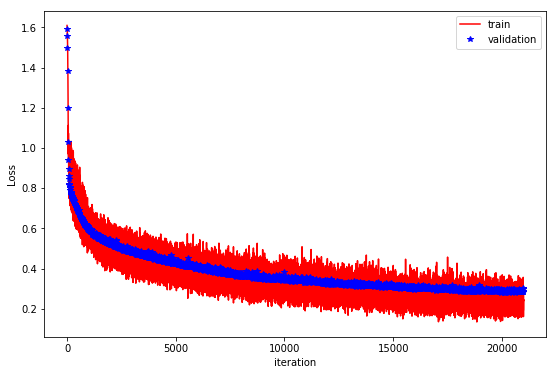

In [33]:
t = np.arange(iteration-1)
plt.figure(figsize = (9,6))
plt.plot(t, np.array(train_loss), 'r-', t[t % 10 == 0], np.array(validation_loss), 'b*')
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

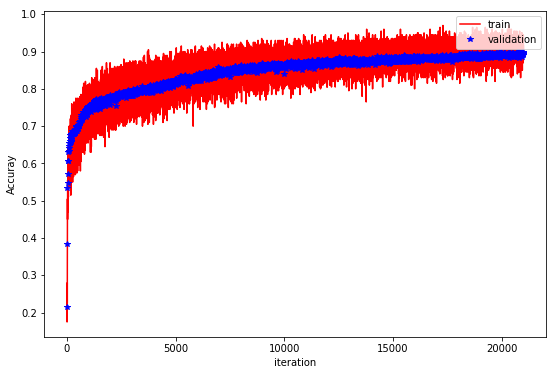

In [31]:
# Plot Accuracies
plt.figure(figsize = (9,6))

plt.plot(t, np.array(train_acc), 'r-', t[t % 10 == 0], validation_acc, 'b*')
plt.xlabel("iteration")
plt.ylabel("Accuray")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [32]:
test_acc = []
pred_labels = []
label = []
with tf.Session(graph=graph) as sess:
    # Restore
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-cnn'))
    
    for x_t, y_t in get_batches(X_test, y_vld, batch_size):
        x_t = x_t.reshape((batch_size,features_num,n_channels))
        feed = {inputs_: x_t,
                labels_: y_t,
                keep_prob_: 1}
       
        batch_acc = sess.run(accuracy, feed_dict=feed)
        preds = sess.run(pred, feed_dict=feed)
        labels = sess.run(label, feed_dict=feed)
        #max_index = np.argmax(prediction)
        #print(max_index)
        test_acc.append(batch_acc)
        pred_labels.append(preds)
        label.append(labels)
    print("Test accuracy: {:.6f}".format(np.mean(test_acc)))
    print("pred value", pred_labels)

INFO:tensorflow:Restoring parameters from checkpoints-cnn\creditGrade.ckpt
Test accuracy: 0.891111
pred value [array([0, 2, 3, 2, 4, 0, 0, 0, 1, 0, 4, 1, 3, 4, 2, 4, 0, 1, 1, 3, 2, 1, 1,
       4, 1, 4, 3, 0, 4, 1, 3, 4, 3, 4, 0, 2, 0, 0, 0, 3, 1, 4, 2, 2, 1, 2,
       2, 3, 4, 0, 4, 2, 4, 3, 1, 4, 3, 1, 3, 1, 4, 2, 3, 3, 0, 3, 4, 3, 3,
       3, 0, 1, 4, 1, 1, 3, 2, 3, 3, 0, 2, 4, 1, 3, 0, 0, 1, 4, 1, 0, 2, 0,
       1, 3, 1, 1, 4, 0, 4, 3, 0, 3, 2, 3, 1, 1, 4, 3, 0, 0, 3, 2, 2, 3, 4,
       2, 1, 3, 4, 0, 1, 3, 1, 3, 2, 3, 3, 4, 2, 4, 1, 2, 2, 1, 3, 4, 2, 1,
       4, 4, 2, 0, 2, 3, 0, 2, 3, 0, 0, 2, 2, 4, 1, 4, 2, 3, 1, 4, 4, 0, 4,
       1, 0, 3, 0, 3, 4, 2, 0, 1, 0, 2, 4, 0, 3, 1, 0, 2, 1, 3, 4, 3, 0, 0,
       1, 1, 2, 0, 3, 4, 3, 1, 0, 4, 1, 3, 1, 2, 2, 1], dtype=int64), array([0, 0, 1, 4, 1, 1, 1, 0, 3, 4, 4, 3, 0, 2, 0, 3, 3, 1, 0, 1, 2, 2, 1,
       3, 3, 4, 3, 3, 3, 3, 4, 3, 2, 2, 4, 3, 2, 1, 4, 1, 2, 3, 1, 0, 4, 2,
       3, 2, 0, 4, 0, 1, 0, 0, 0, 4, 3, 4, 3, 3, 4, 2, 3, 3